In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
csv_files = ['/content/drive/MyDrive/Stock/data/FPT.csv','/content/drive/MyDrive/Stock/data/MSN.csv','/content/drive/MyDrive/Stock/data/PNJ.csv','/content/drive/MyDrive/Stock/data/VIC.csv']

# Create a list to save data from CSV files
dataframes = []

# Read and save data from each CSV file to a list
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Merge DataFrames into one large DataFrame
stock_dataframe = pd.concat(dataframes, ignore_index=True)
stock_dataframe.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [5]:
stock_dataframe.shape

(459335, 8)

In [6]:
stock_dataframe.describe()

,Open,High,Low,Close,Volume,Open Interest
count,459335.000000,459335.000000,459335.000000,459335.000000,4.593350e+05,459335.0
mean,74.545826,74.626579,74.481065,74.546183,4.909390e+03,0.0
std,23.023346,23.038201,23.011619,23.024380,1.902104e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+00,0.0
25%,54.190000,54.250000,54.150000,54.190000,3.600000e+02,0.0
50%,75.730000,75.920000,75.600000,75.720000,1.500000e+03,0.0
75%,90.100000,90.200000,90.000000,90.100000,4.920000e+03,0.0
max,126.100000,126.500000,126.100000,126.500000,3.300680e+06,0.0


In [7]:
def load_data(dataframe,start,end):
    """"
    Load data for the specified company an data range.
    :param start:The starting date for the data range(string or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return:  A dataframe containig the relevant  stock data (pandas.DataFrame)
    """
    dataframe=dataframe.rename(columns={'Date/Time':'Date Time'})
    dataframe['Date Time'] = pd.to_datetime(dataframe['Date Time'])
    dataframe=dataframe.loc[(dataframe['Date Time']>start)&(dataframe['Date Time']<end),:]
    return dataframe

In [8]:
START = dt.datetime(2016,1,1)
END = dt.datetime(2020,1,1)
START_TEST=END
df = load_data(stock_dataframe,START,END)

In [9]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [10]:
# Set the number of days for prediction
prediction_days=60

#Intialize empty lists for training data input and output
x_train=[]
y_train=[]

#Iterate tthrough the scaled data, starting ffrom the prediction days index
for x in range(prediction_days,len(scaled_data)):
    #Append the previous prediction days values to x_train
    x_train.append(scaled_data[x-prediction_days:x,0])
    #Append the current value to y_train
    y_train.append(scaled_data[x,0])

#Convert the x_train and y_train lists to numpy arrays
x_train, y_train=np.array(x_train),np.array(y_train)

#reshape x_train to a D array with the appropriate dimensions for the LSTM Model
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [11]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [12]:
model=LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [13]:
# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/50
8084/8088 [============================>.] - ETA: 0s - loss: 0.0012

8088/8088 [==============================] - 108s 12ms/step - loss: 0.0012
Epoch 2/50
8088/8088 [==============================] - ETA: 0s - loss: 4.7549e-04

8088/8088 [==============================] - 97s 12ms/step - loss: 4.7549e-04
Epoch 3/50
8085/8088 [============================>.] - ETA: 0s - loss: 4.4927e-04

8088/8088 [==============================] - 96s 12ms/step - loss: 4.4931e-04
Epoch 4/50
8084/8088 [============================>.] - ETA: 0s - loss: 4.3660e-04

8088/8088 [==============================] - 95s 12ms/step - loss: 4.3664e-04
Epoch 5/50
8088/8088 [==============================] - ETA: 0s - loss: 4.1708e-04

8088/8088 [==============================] - 95s 12ms/step - loss: 4.1708e-04
Epoch 6/50
8084/8088 [============================>.] - ETA: 0s - loss: 4.0446e-04

8088/8088 [==============================] - 93s 12ms/step - loss: 4.0446e-04
Epoch 7/50
8084/8088 [============================>.] - ETA: 0s - loss: 3.9509e-04

8088/8088 [==============================] - 96s 12ms/step - loss: 3.9527e-04
Epoch 8/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.9019e-04

8088/8088 [==============================] - 95s 12ms/step - loss: 3.9017e-04
Epoch 9/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.8082e-04

8088/8088 [==============================] - 93s 12ms/step - loss: 3.8082e-04
Epoch 10/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.7640e-04

8088/8088 [==============================] - 93s 11ms/step - loss: 3.7641e-04
Epoch 11/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.7146e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.7145e-04
Epoch 12/50
8084/8088 [============================>.] - ETA: 0s - loss: 3.7234e-04

8088/8088 [==============================] - 95s 12ms/step - loss: 3.7229e-04
Epoch 13/50
8088/8088 [==============================] - ETA: 0s - loss: 3.6615e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.6615e-04
Epoch 14/50
8084/8088 [============================>.] - ETA: 0s - loss: 3.6811e-04

8088/8088 [==============================] - 96s 12ms/step - loss: 3.6814e-04
Epoch 15/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.6255e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.6254e-04
Epoch 16/50
8088/8088 [==============================] - ETA: 0s - loss: 3.6461e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.6461e-04
Epoch 17/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.5912e-04

8088/8088 [==============================] - 93s 12ms/step - loss: 3.5911e-04
Epoch 18/50
8084/8088 [============================>.] - ETA: 0s - loss: 3.5939e-04

8088/8088 [==============================] - 93s 12ms/step - loss: 3.5939e-04
Epoch 19/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.5833e-04

8088/8088 [==============================] - 96s 12ms/step - loss: 3.5829e-04
Epoch 20/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.5969e-04

8088/8088 [==============================] - 96s 12ms/step - loss: 3.5970e-04
Epoch 21/50
8088/8088 [==============================] - ETA: 0s - loss: 3.5543e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.5543e-04
Epoch 22/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.5651e-04

8088/8088 [==============================] - 91s 11ms/step - loss: 3.5651e-04
Epoch 23/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.5531e-04

8088/8088 [==============================] - 93s 12ms/step - loss: 3.5538e-04
Epoch 24/50
8088/8088 [==============================] - ETA: 0s - loss: 3.5430e-04

8088/8088 [==============================] - 92s 11ms/step - loss: 3.5430e-04
Epoch 25/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.5492e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.5490e-04
Epoch 26/50
8086/8088 [============================>.] - ETA: 0s - loss: 3.5230e-04

8088/8088 [==============================] - 91s 11ms/step - loss: 3.5230e-04
Epoch 27/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.5060e-04

8088/8088 [==============================] - 91s 11ms/step - loss: 3.5057e-04
Epoch 28/50
8086/8088 [============================>.] - ETA: 0s - loss: 3.4975e-04

8088/8088 [==============================] - 95s 12ms/step - loss: 3.4972e-04
Epoch 29/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.5058e-04

8088/8088 [==============================] - 93s 12ms/step - loss: 3.5057e-04
Epoch 30/50
8086/8088 [============================>.] - ETA: 0s - loss: 3.4757e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.4756e-04
Epoch 31/50
8088/8088 [==============================] - ETA: 0s - loss: 3.4815e-04

8088/8088 [==============================] - 93s 12ms/step - loss: 3.4815e-04
Epoch 32/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4784e-04

8088/8088 [==============================] - 90s 11ms/step - loss: 3.4782e-04
Epoch 33/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4860e-04

8088/8088 [==============================] - 91s 11ms/step - loss: 3.4859e-04
Epoch 34/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.4592e-04

8088/8088 [==============================] - 92s 11ms/step - loss: 3.4594e-04
Epoch 35/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4608e-04

8088/8088 [==============================] - 91s 11ms/step - loss: 3.4607e-04
Epoch 36/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4662e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.4661e-04
Epoch 37/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4622e-04

8088/8088 [==============================] - 103s 13ms/step - loss: 3.4623e-04
Epoch 38/50
8084/8088 [============================>.] - ETA: 0s - loss: 3.4636e-04

8088/8088 [==============================] - 105s 13ms/step - loss: 3.4634e-04
Epoch 39/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.4263e-04

8088/8088 [==============================] - 104s 13ms/step - loss: 3.4266e-04
Epoch 40/50
8088/8088 [==============================] - ETA: 0s - loss: 3.4099e-04

8088/8088 [==============================] - 104s 13ms/step - loss: 3.4099e-04
Epoch 41/50
8088/8088 [==============================] - ETA: 0s - loss: 3.4267e-04

8088/8088 [==============================] - 104s 13ms/step - loss: 3.4267e-04
Epoch 42/50
8086/8088 [============================>.] - ETA: 0s - loss: 3.4392e-04

8088/8088 [==============================] - 103s 13ms/step - loss: 3.4392e-04
Epoch 43/50
8084/8088 [============================>.] - ETA: 0s - loss: 3.4189e-04

8088/8088 [==============================] - 104s 13ms/step - loss: 3.4185e-04
Epoch 44/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4438e-04

8088/8088 [==============================] - 103s 13ms/step - loss: 3.4437e-04
Epoch 45/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4322e-04

8088/8088 [==============================] - 103s 13ms/step - loss: 3.4320e-04
Epoch 46/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.4297e-04

8088/8088 [==============================] - 103s 13ms/step - loss: 3.4293e-04
Epoch 47/50
8087/8088 [============================>.] - ETA: 0s - loss: 3.4286e-04

8088/8088 [==============================] - 95s 12ms/step - loss: 3.4285e-04
Epoch 48/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.4257e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.4252e-04
Epoch 49/50
8085/8088 [============================>.] - ETA: 0s - loss: 3.4142e-04

8088/8088 [==============================] - 94s 12ms/step - loss: 3.4139e-04
Epoch 50/50
8086/8088 [============================>.] - ETA: 0s - loss: 3.4222e-04

8088/8088 [==============================] - 92s 11ms/step - loss: 3.4223e-04


In [15]:
def load_data_test(dataframe,ticker,start,end):
    """"
    Load data for the specified company an data range.
    :param start:The starting date for the data range(string or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return:  A dataframe containig the relevant  stock data (pandas.DataFrame)
    """
    dataframe=dataframe.loc[dataframe['Ticker'] == ticker, :]
    dataframe=dataframe.rename(columns={'Date/Time':'Date Time'})
    dataframe['Date Time'] = pd.to_datetime(dataframe['Date Time'])
    dataframe=dataframe.loc[(dataframe['Date Time']>start)&(dataframe['Date Time']<end),:]
    return dataframe

In [18]:
TICKER = 'FPT'
# Load the test data for the specified company and date range
test_data=load_data_test(stock_dataframe,
ticker=TICKER,
start=START_TEST,
end=dt.datetime.now()
)
# Extract the actual closing price from the test data
actual_price=test_data['Close'].values

#Concatenate the training and test data along the 'Close' column
total_dataset=pd.concat((df['Close'],test_data['Close']),axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values

#Reshape the model inputs to a 2D array with a single column
model_inputs=model_inputs.reshape(-1,1)

# Apply the same scaling used for trainig data to model inputs
model_inputs=scaler.transform(model_inputs)

In [19]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

1625/1625 [==============================] - 9s 5ms/step


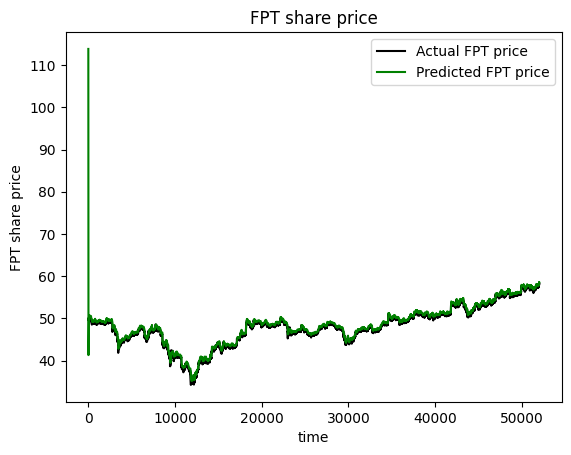

In [21]:
# Plot the actual prices using a black line
plt.plot(actual_price, color='black', label=f"Actual {TICKER} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {TICKER} price")

# Set the title of the plot using the company name
plt.title(f"{TICKER} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{TICKER} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [22]:
TICKER = 'MSN'
# Load the test data for the specified company and date range
test_data=load_data_test(stock_dataframe,
ticker=TICKER,
start=START_TEST,
end=dt.datetime.now()
)
# Extract the actual closing price from the test data
actual_price=test_data['Close'].values

#Concatenate the training and test data along the 'Close' column
total_dataset=pd.concat((df['Close'],test_data['Close']),axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values

#Reshape the model inputs to a 2D array with a single column
model_inputs=model_inputs.reshape(-1,1)

# Apply the same scaling used for trainig data to model inputs
model_inputs=scaler.transform(model_inputs)

In [23]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

1620/1620 [==============================] - 11s 7ms/step


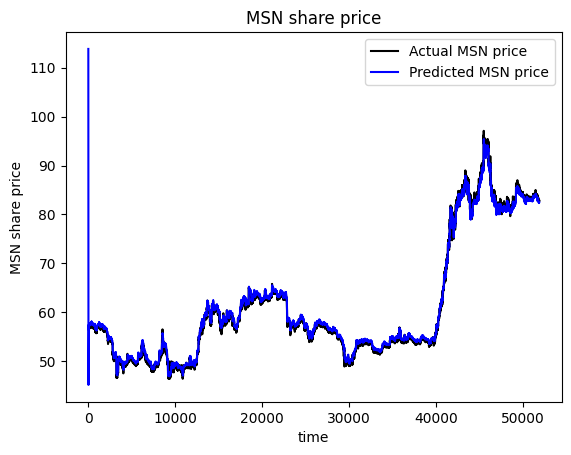

In [24]:
# Plot the actual prices using a black line
plt.plot(actual_price, color='black', label=f"Actual {TICKER} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='blue', label=f"Predicted {TICKER} price")

# Set the title of the plot using the company name
plt.title(f"{TICKER} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{TICKER} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [25]:
TICKER = 'PNJ'
# Load the test data for the specified company and date range
test_data=load_data_test(stock_dataframe,
ticker=TICKER,
start=START_TEST,
end=dt.datetime.now()
)
# Extract the actual closing price from the test data
actual_price=test_data['Close'].values

#Concatenate the training and test data along the 'Close' column
total_dataset=pd.concat((df['Close'],test_data['Close']),axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values

#Reshape the model inputs to a 2D array with a single column
model_inputs=model_inputs.reshape(-1,1)

# Apply the same scaling used for trainig data to model inputs
model_inputs=scaler.transform(model_inputs)

In [26]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

1508/1508 [==============================] - 10s 6ms/step


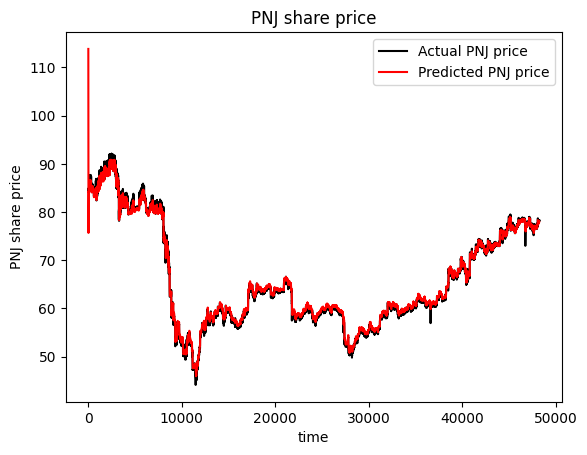

In [27]:
# Plot the actual prices using a black line
plt.plot(actual_price, color='black', label=f"Actual {TICKER} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='red', label=f"Predicted {TICKER} price")

# Set the title of the plot using the company name
plt.title(f"{TICKER} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{TICKER} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [28]:
TICKER = 'VIC'
# Load the test data for the specified company and date range
test_data=load_data_test(stock_dataframe,
ticker=TICKER,
start=START_TEST,
end=dt.datetime.now()
)
# Extract the actual closing price from the test data
actual_price=test_data['Close'].values

#Concatenate the training and test data along the 'Close' column
total_dataset=pd.concat((df['Close'],test_data['Close']),axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values

#Reshape the model inputs to a 2D array with a single column
model_inputs=model_inputs.reshape(-1,1)

# Apply the same scaling used for trainig data to model inputs
model_inputs=scaler.transform(model_inputs)

In [29]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

1513/1513 [==============================] - 9s 6ms/step


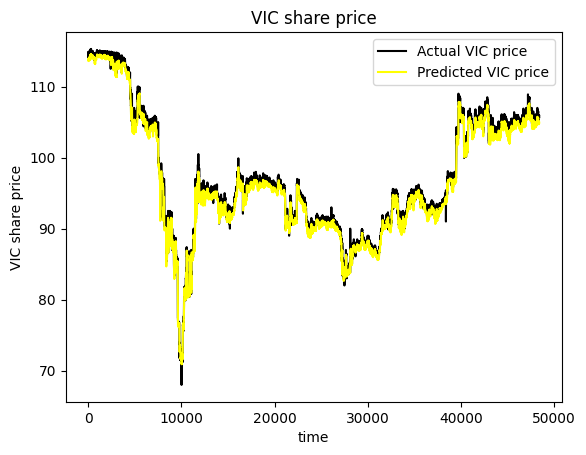

In [30]:
# Plot the actual prices using a black line
plt.plot(actual_price, color='black', label=f"Actual {TICKER} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='yellow', label=f"Predicted {TICKER} price")

# Set the title of the plot using the company name
plt.title(f"{TICKER} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{TICKER} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()